## Import section. Use tensorflow 1.0

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal,Bernoulli,Beta,Categorical,InverseGamma

plt.style.use('ggplot')

## Building models

In [2]:
x = Normal(mu=tf.constant(0.0),sigma=tf.constant(1.0))
Normal(mu=tf.zeros(5), sigma=tf.ones(5))
y = tf.constant(5.0)

### Generative model, Beta Bernoulli

In [3]:
theta = Beta(a=1.0, b=1.0)
x = Bernoulli(p=tf.ones(50) * theta)
x

<ed.RandomVariable 'Bernoulli/' shape=(50,) dtype=int32>

## Regression model

In [4]:
# Populate data
def build_dataset(N,w,noise_std = 0.1):
    D = len(w)
    x = np.random.randn(N,D)
    y = np.dot(x,w) + np.random.normal(0,noise_std,size=N)
    return x,y

N = 40  # number of data points
D = 10  # number of features
w_true = np.random.randn(D)
X_train, y_train = build_dataset(N,w_true)
X_test, y_test = build_dataset(N,w_true)

In [5]:
# Build Model
X = tf.placeholder(tf.float32, [N, D])
w = Normal(mu=tf.zeros(D), sigma=tf.ones(D))
b = Normal(mu=tf.zeros(1), sigma=tf.ones(1))
y = Normal(mu=ed.dot(X, w) + b, sigma=tf.ones(N))

In [6]:
# Inference
qw = Normal(mu=tf.Variable(tf.random_normal([D])),sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(mu=tf.Variable(tf.random_normal([1])),sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [7]:
inference = ed.KLqp(latent_vars = {w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 0s | Loss: 62.671


In [8]:
# Predictive posterior
y_post = ed.copy(y,{w:qw,b:qb})
# Evaluation
ed.evaluate('mean_squared_error',data={X:X_train,y:y_post})

8.9091434

## Mixture model

In [9]:
# Populate data
def build_mixture_dataset(N):
    pi = np.array([0.3,0.2,0.5])
    mus = [[1,1],[1,-1],[-1,-1]]
    stds = [[0.1,0.1],[0.1,0.1],[0.1,0.1]]
    x = np.zeros((N,2), dtype=np.float32)
    y = np.zeros((N,1), dtype=np.int)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1,pi))
        x[n,:] = np.random.multivariate_normal(mus[k],np.diag(stds[k]))
        y[n]=k
    return x,y

N = 1000
D = 2
K = 3
beta = Normal
x_train,y_train = build_mixture_dataset(N)
y_ph = tf.placeholder(tf.int16,[N,1])

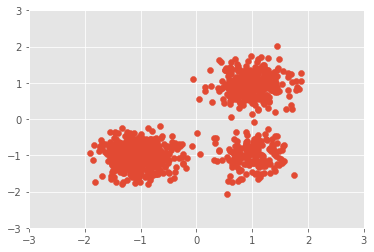

In [10]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.show()

## SVI without subsampling

In [11]:
# Type 1
mu = Normal(mu=tf.zeros([K, D]), sigma=tf.ones([K, D]))
sigma = InverseGamma(alpha=tf.ones([K, D]), beta=tf.ones([K, D]))
c = Categorical(logits=tf.zeros([N, K]))
x = Normal(mu=tf.gather(mu, c), sigma=tf.gather(sigma, c))

qmu = Normal(
    mu=tf.Variable(tf.random_normal([K, D])),
    sigma=tf.nn.softplus(tf.Variable(tf.zeros([K, D]))))
qsigma = InverseGamma(
    alpha=tf.nn.softplus(tf.Variable(tf.random_normal([K, D]))),
    beta=tf.nn.softplus(tf.Variable(tf.random_normal([K, D]))))

# inference = ed.inferences.VariationalInference({mu:qmu, sigma:qsigma}, data={x:x_train}) #abstract class
inference = ed.KLpq({mu:qmu, sigma:qsigma}, data={x:x_train})
inference.run(n_samples=100,n_iter=1000)

# inference = ed.inferences.ScoreKLqp({mu:qmu, sigma:qsigma}, data={x:x_train})
# inference.run(n_samples=100,n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 28s | Loss: -29.010


### Criticism

In [12]:
# Predictive posterior
x_post = ed.copy(x,{mu:qmu,sigma:qsigma})
# Evaluation
ed.evaluate('log_likelihood',data={x_post:x_train})

-1.5317492

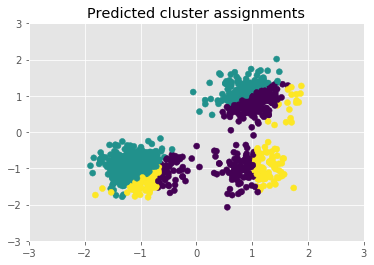

In [13]:
# Visualization of prediction
import matplotlib.cm as cm

mu_sample = qmu.sample(100)
sigma_sample = qsigma.sample(100)
x_post = Normal(mu=tf.ones([N,1,1,1])*mu_sample,sigma=tf.ones([N,1,1,1])*tf.sqrt(sigma_sample))
x_broadcasted = tf.tile(tf.reshape(x_train,[N,1,1,D]),[1,100,K,1])

log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

clusters = tf.argmax(log_liks, 1).eval()

plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

## Stochastic VB with subsampling

In [14]:
M = 128  # minibatch size
beta = Normal(mu=tf.zeros([K, D]), sigma=tf.ones([K, D]))
z = Categorical(logits=tf.zeros([M, K]))
x = Normal(mu=tf.gather(beta, z), sigma=tf.ones([M, D]))

qbeta = Normal(mu=tf.Variable(tf.zeros([K, D])),
               sigma=tf.nn.softplus(tf.Variable(tf.zeros([K, D]))))
qz_variables = tf.Variable(tf.zeros([M, K]))
qz = Categorical(logits=qz_variables)

x_ph = tf.placeholder(tf.float32, [M,2])
inference_global = ed.KLqp({beta: qbeta}, data={x: x_ph, z: qz})
inference_local = ed.KLqp({z: qz}, data={x: x_ph, beta: qbeta})

In [15]:
inference_global.initialize(scale={x: float(N) / M, z: float(N) / M})
inference_local.initialize(scale={x: float(N) / M, z: float(N) / M})

In [16]:
def next_batch(x,M):
    ind = np.random.permutation(len(x_train))
    ind=ind[:M]
    return x[ind]

qz_init = tf.variables_initializer([qz_variables])
tf.initialize_all_variables().run()

for _ in range(500):
    x_batch = next_batch(x_train,M)
    for _ in range(10):  # make local inferences
        inference_local.update(feed_dict={x_ph: x_batch})
    # update global parameters
    inference_global.update(feed_dict={x_ph: x_batch})
    # reinitialize the local factors
    qz_init.run()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


## Criticism

In [17]:
# Predictive posterior
x_post = ed.copy(x,{z:qz,beta:qbeta})
x_test = x_train[:M]
y_test = y_train[:M]
# Evaluation
ed.evaluate('log_likelihood',data={x_post:x_test})

-1.4699172